### LSTM for predicting V, A and D (norm) 

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


data=pd.read_csv('Emo_Bank_VAD.csv')

print(data.columns)
print('')
print(data.shape)
print(data.head())
print('')
print(data.dtypes)



Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


In [17]:
data.isnull().sum()

id       0
split    0
V        0
A        0
D        0
text     0
dtype: int64

In [18]:
# Normalize columns 
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to the columns of interest
data[['V', 'A', 'D']] = scaler.fit_transform(data[['V', 'A', 'D']])


print(data.head())

                    id  split         V         A         D  \
0  110CYL068_1036_1079  train  0.058824 -0.076923  0.173554   
1  110CYL068_1079_1110   test -0.058824  0.000000 -0.157025   
2  110CYL068_1127_1130  train  0.058824 -0.076923  0.008264   
3  110CYL068_1137_1188  train  0.317647 -0.076923  0.190083   
4  110CYL068_1189_1328  train  0.382353  0.130769  0.388430   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  


In [19]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data["text"], data[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)


In [20]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess(text):
    text = text.lower()  # Convert to lower case
    text = word_tokenize(text)  # Tokenize
    text = [w for w in text if w.isalnum() and w not in stop_words]  # Remove stopwords and non-alphanumeric words
    text = " ".join(text)  # Join back into a single string
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    return text


x_train = x_train.apply(preprocess)
x_val = x_val.apply(preprocess)
x_test = x_test.apply(preprocess)

x_train.head()

[nltk_data] Downloading package punkt to /Users/stef_tse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stef_tse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5214                                      asean talks end
4784                   antibiotic ketek dangerous thought
708                     death throughout death everywhere
6369    fascinating collection artifacts pertaining sh...
2135    rat pack originally frank sinatra dean martin ...
Name: text, dtype: object

In [21]:
# Create word-to-index dictionary and tokenizer
word_to_counts = Counter(" ".join(x_train).split())  
n_words = len(word_to_counts)  

tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

# Convert text data to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_length = 170

# Pad sequences to the same length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length)

# Convert y data to tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)

print(f"Padded sequence shapes: x_train_pad={x_train_pad.shape}, x_val_pad={x_val_pad.shape}, x_test_pad={x_test_pad.shape}")
print(f"Tensor shapes: y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}")

# Create datasets for training, validation, and testing
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pad, y_train)).shuffle(len(x_train_pad)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_pad, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_pad, y_test)).batch(32)




Padded sequence shapes: x_train_pad=(8023, 170), x_val_pad=(892, 170), x_test_pad=(991, 170)
Tensor shapes: y_train=(8023, 3), y_val=(892, 3), y_test=(991, 3)


In [22]:
# Build the LSTM model
lstm_VAD_norm = Sequential()
lstm_VAD_norm.add(Embedding(input_dim=n_words, output_dim=128, input_length=max_length))
lstm_VAD_norm.add(LSTM(128, return_sequences=True))
lstm_VAD_norm.add(Dropout(0.5))
lstm_VAD_norm.add(LSTM(64))
lstm_VAD_norm.add(Dropout(0.5))
lstm_VAD_norm.add(Dense(3, activation='tanh')) #activation="linear" gives very bad results for normilized variables
lstm_VAD_norm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 170, 128)          1764736   
                                                                 
 lstm_2 (LSTM)               (None, 170, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 170, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1945923 (7.42 MB)
Trainable params: 1945

In [23]:
#compile and train

epochs = 60
#batch_size=32
optimizer = Adam(learning_rate=0.0001)


keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001), ModelCheckpoint('best_model_VAD_norm.h5', monitor='val_loss', save_best_only=True, mode='min',verbose=1)]

lstm_VAD_norm.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', rmse])
history = lstm_VAD_norm.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[keras_callbacks])


Epoch 1/60
251/251 [==============================] - ETA: 0s - loss: 0.0373 - mae: 0.1418 - rmse: 0.1635
Epoch 1: val_loss improved from inf to 0.03880, saving model to best_model_VAD_norm.h5
251/251 [==============================] - 78s 253ms/step - loss: 0.0373 - mae: 0.1418 - rmse: 0.1635 - val_loss: 0.0388 - val_mae: 0.1452 - val_rmse: 0.1669


/Users/stef_tse/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
251/251 [==============================] - ETA: 0s - loss: 0.0362 - mae: 0.1393 - rmse: 0.1605
Epoch 2: val_loss improved from 0.03880 to 0.03820, saving model to best_model_VAD_norm.h5
251/251 [==============================] - 57s 226ms/step - loss: 0.0362 - mae: 0.1393 - rmse: 0.1605 - val_loss: 0.0382 - val_mae: 0.1433 - val_rmse: 0.1648
Epoch 3/60
251/251 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.1346 - rmse: 0.1553
Epoch 3: val_loss improved from 0.03820 to 0.03700, saving model to best_model_VAD_norm.h5
251/251 [==============================] - 59s 236ms/step - loss: 0.0342 - mae: 0.1346 - rmse: 0.1553 - val_loss: 0.0370 - val_mae: 0.1413 - val_rmse: 0.1633
Epoch 4/60
251/251 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.1263 - rmse: 0.1459
Epoch 4: val_loss improved from 0.03700 to 0.03621, saving model to best_model_VAD_norm.h5
251/251 [==============================] - 57s 228ms/step - loss: 0.0304 - mae: 0.1263 - rmse

In [25]:
# Load the best saved model
best_lstm_VAD_norm = load_model('best_model_VAD_norm.h5', custom_objects={'rmse': rmse})

# Evaluate the model
train_loss, train_mae, train_rmse = best_lstm_VAD_norm.evaluate(train_dataset)
val_loss, val_mae, val_rmse = best_lstm_VAD_norm.evaluate(val_dataset)
test_loss, test_mae, test_rmse = best_lstm_VAD_norm.evaluate(test_dataset)

# Print evaluation metrics
print("Training Loss:", train_loss)
print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)

print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)
print("Validation RMSE:", val_rmse)

print("Testing Loss:", test_loss)
print("Testing MAE:", test_mae)
print("Testing RMSE:", test_rmse)

# Predict on the datasets
y_train_pred = best_lstm_VAD_norm.predict(x_train_pad)
y_val_pred = best_lstm_VAD_norm.predict(x_val_pad)
y_test_pred = best_lstm_VAD_norm.predict(x_test_pad)

# Compute and print detailed metrics for each target variable (V, A, D)
for i, target in enumerate(["V", "A", "D"]):
    print(f"\nMetrics for target variable {target}:")
    
    y_train_true = y_train[:, i].numpy()
    y_train_pred_target = y_train_pred[:, i]
    train_mse = mean_squared_error(y_train_true, y_train_pred_target)
    train_mae = mean_absolute_error(y_train_true, y_train_pred_target)
    train_rmse = np.sqrt(train_mse)
    print(f"Train {target} - MSE: {train_mse:.2f}")
    print(f"Train {target} - MAE: {train_mae:.2f}")
    print(f"Train {target} - RMSE: {train_rmse:.2f}")

    y_val_true = y_val[:, i].numpy()
    y_val_pred_target = y_val_pred[:, i]
    val_mse = mean_squared_error(y_val_true, y_val_pred_target)
    val_mae = mean_absolute_error(y_val_true, y_val_pred_target)
    val_rmse = np.sqrt(val_mse)
    print(f"Validation {target} - MSE: {val_mse:.2f}")
    print(f"Validation {target} - MAE: {val_mae:.2f}")
    print(f"Validation {target} - RMSE: {val_rmse:.2f}")

    y_test_true = y_test[:, i].numpy()
    y_test_pred_target = y_test_pred[:, i]
    test_mse = mean_squared_error(y_test_true, y_test_pred_target)
    test_mae = mean_absolute_error(y_test_true, y_test_pred_target)
    test_rmse = np.sqrt(test_mse)
    print(f"Test {target} - MSE: {test_mse:.2f}")
    print(f"Test {target} - MAE: {test_mae:.2f}")
    print(f"Test {target} - RMSE: {test_rmse:.2f}")

31/31 [==============================] - 3s 88ms/step - loss: 0.0363 - mae: 0.1404 - rmse: 0.1604
Training Loss: 0.026878252625465393
Training MAE: 0.11687127500772476
Training RMSE: 0.13469849526882172
Validation Loss: 0.03621220961213112
Validation MAE: 0.14062699675559998
Validation RMSE: 0.1615990847349167
Testing Loss: 0.03627021610736847
Testing MAE: 0.1404414176940918
Testing RMSE: 0.16042865812778473
31/31 [==============================] - 1s 48ms/step

Metrics for target variable V:
Train V - MSE: 0.03
Train V - MAE: 0.11
Train V - RMSE: 0.16
Validation V - MSE: 0.04
Validation V - MAE: 0.14
Validation V - RMSE: 0.19
Test V - MSE: 0.04
Test V - MAE: 0.14
Test V - RMSE: 0.19

Metrics for target variable A:
Train A - MSE: 0.03
Train A - MAE: 0.13
Train A - RMSE: 0.18
Validation A - MSE: 0.04
Validation A - MAE: 0.15
Validation A - RMSE: 0.20
Test A - MSE: 0.04
Test A - MAE: 0.15
Test A - RMSE: 0.20

Metrics for target variable D:
Train D - MSE: 0.02
Train D - MAE: 0.11
Train D 

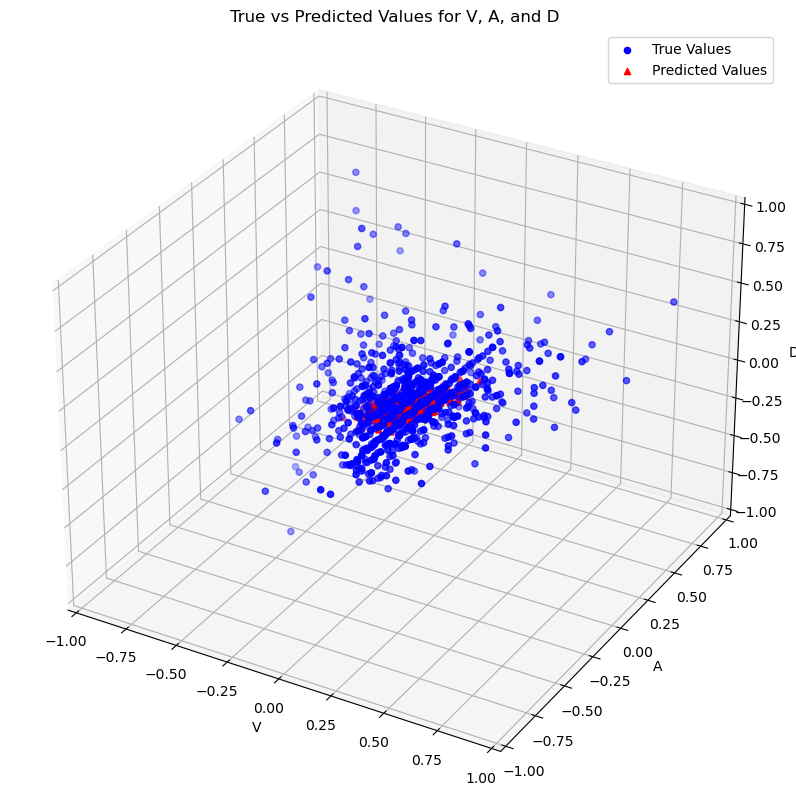

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot for true vs predicted
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot true values
ax.scatter(y_test[:, 0], y_test[:, 1], y_test[:, 2], c='b', marker='o', label='True Values')
# Plot predicted values
ax.scatter(y_test_pred[:, 0], y_test_pred[:, 1], y_test_pred[:, 2], c='r', marker='^', label='Predicted Values')

# Set axes limits to [-1, 1]
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel('V')
ax.set_ylabel('A')
ax.set_zlabel('D')
ax.set_title('True vs Predicted Values for V, A, and D')
ax.legend()

plt.show()


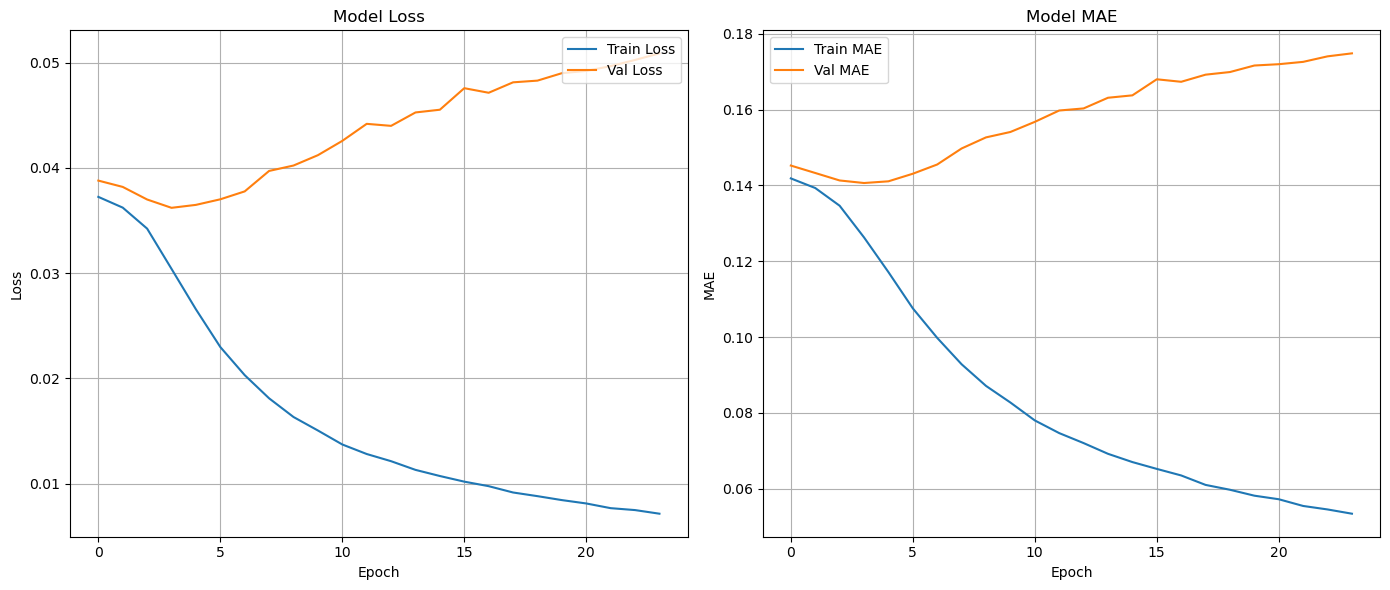

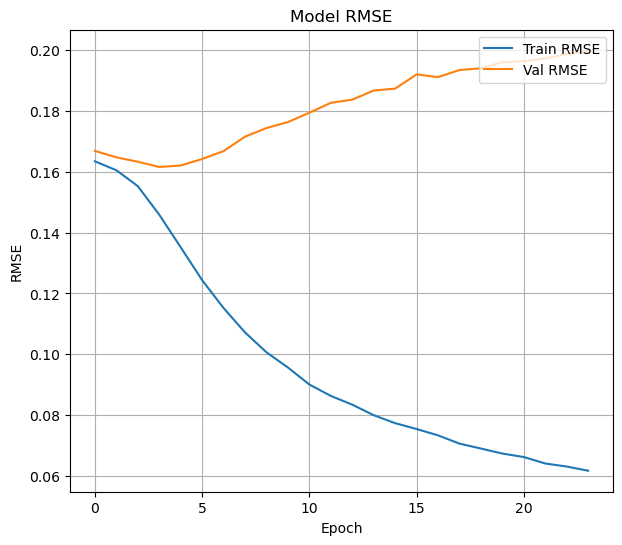

In [27]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot training & validation RMSE
plt.figure(figsize=(7, 6))

# RMSE Plot
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Val RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


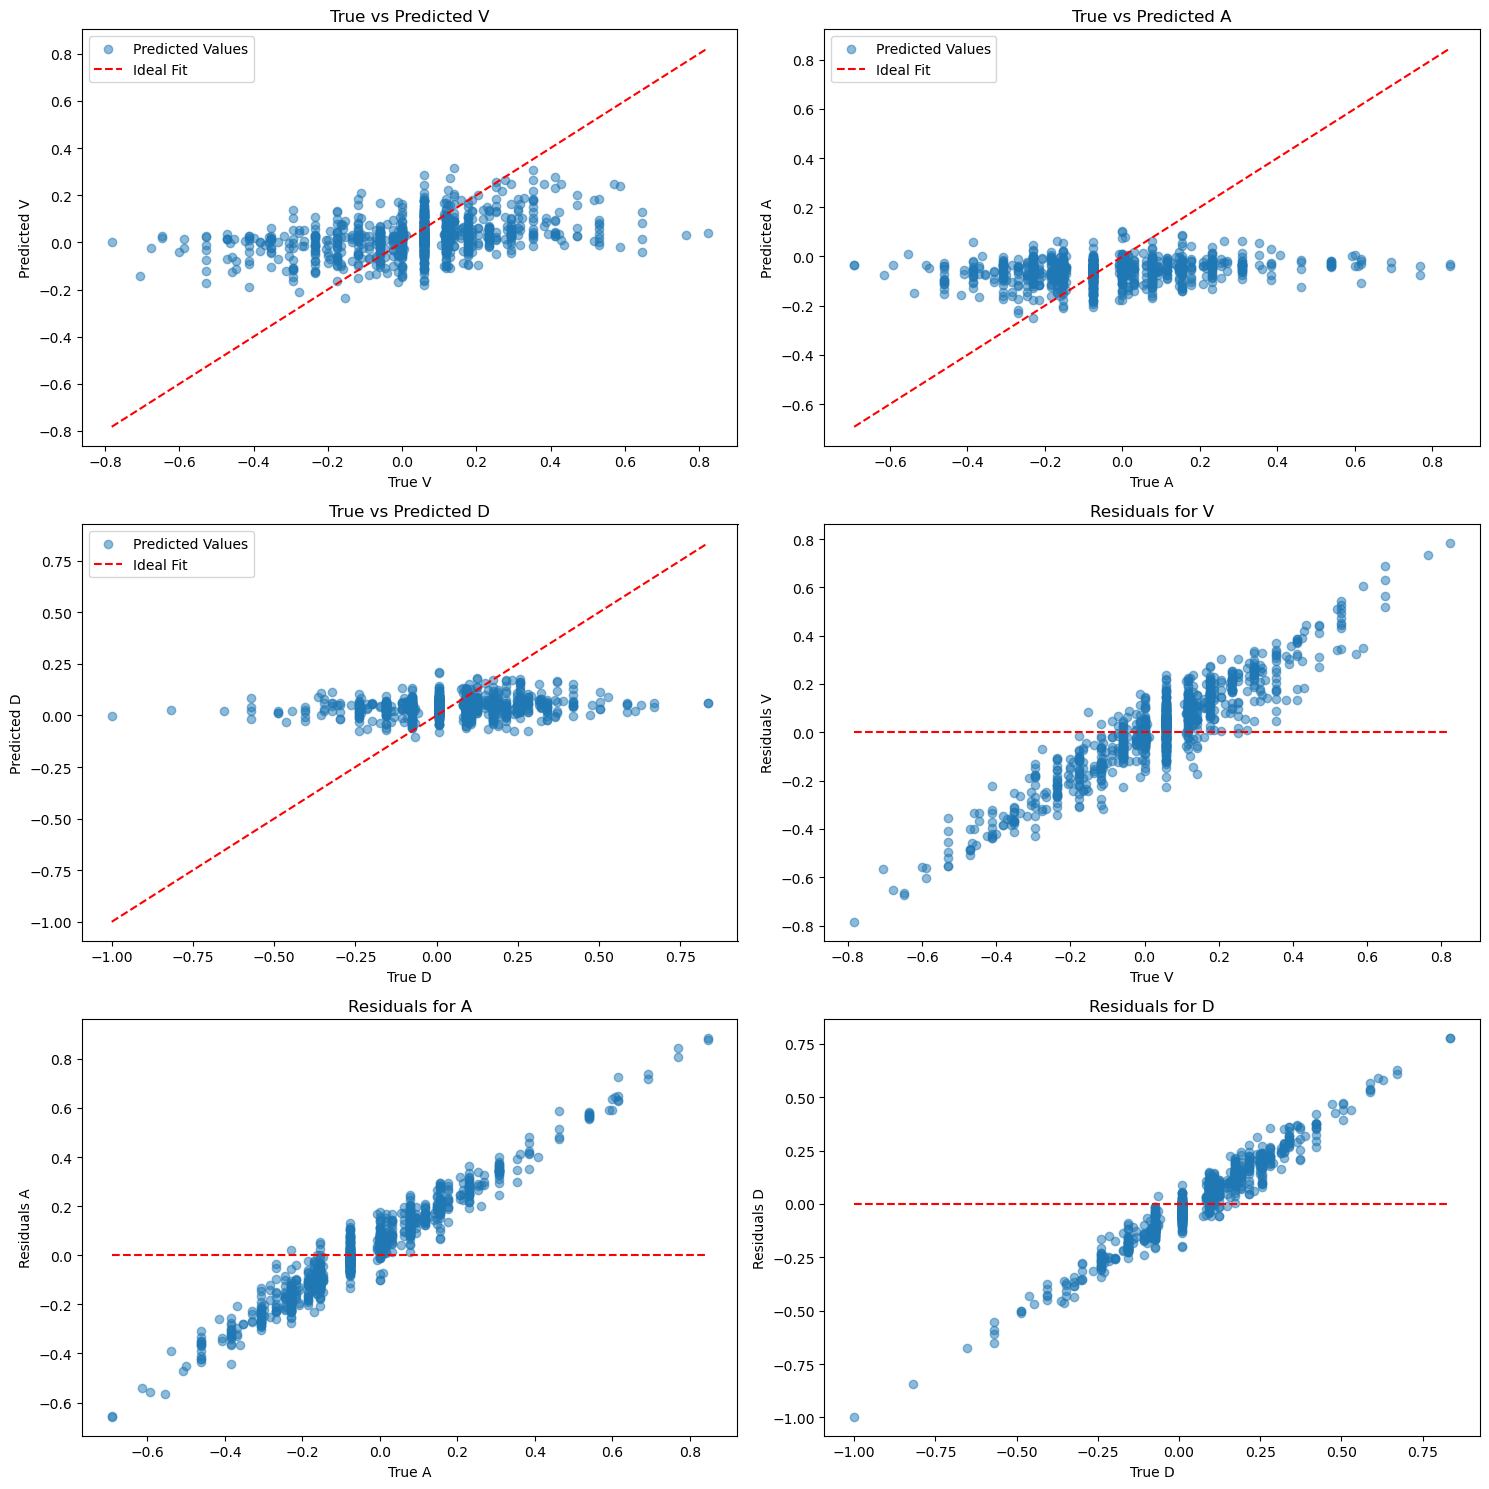

In [28]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot True Values vs Predictions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
targets = ["V", "A", "D"]

for i, target in enumerate(targets):
    # True vs Predicted Values
    axes[i].scatter(y_test[:, i], y_test_pred[:, i], alpha=0.5, label='Predicted Values')
    axes[i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r--', label='Ideal Fit')
    axes[i].set_xlabel(f'True {target}')
    axes[i].set_ylabel(f'Predicted {target}')
    axes[i].set_title(f'True vs Predicted {target}')
    axes[i].legend()

for i, target in enumerate(targets):
    # Residuals Plot
    axes[i + 3].scatter(y_test[:, i], residuals[:, i], alpha=0.5)
    axes[i + 3].hlines(0, min(y_test[:, i]), max(y_test[:, i]), colors='r', linestyles='dashed')
    axes[i + 3].set_xlabel(f'True {target}')
    axes[i + 3].set_ylabel(f'Residuals {target}')
    axes[i + 3].set_title(f'Residuals for {target}')

plt.tight_layout()
plt.show()

In [29]:
# Create DataFrames for each dataset and target variable
for i, target in enumerate(["V", "A", "D"]):
    df_train = pd.DataFrame({
        'Text': x_train.values,
        f'True_{target}': y_train[:, i],
        f'Predicted_{target}': y_train_pred[:, i]
    })
    df_val = pd.DataFrame({
        'Text': x_val.values,
        f'True_{target}': y_val[:, i],
        f'Predicted_{target}': y_val_pred[:, i]
    })
    df_test = pd.DataFrame({
        'Text': x_test.values,
        f'True_{target}': y_test[:, i],
        f'Predicted_{target}': y_test_pred[:, i]
    })


    print(f"\nSample DataFrame for train set, target variable {target}:")
    print(df_train.head())

    print(f"\nSample DataFrame for validation set, target variable {target}:")
    print(df_val.head())

    print(f"\nSample DataFrame for test set, target variable {target}:")
    print(df_test.head())


Sample DataFrame for train set, target variable V:
                                                Text    True_V  Predicted_V
0                                    asean talks end  0.058824     0.036166
1                 antibiotic ketek dangerous thought -0.235294    -0.074069
2                  death throughout death everywhere -0.352941    -0.104413
3  fascinating collection artifacts pertaining sh...  0.388235     0.216344
4  rat pack originally frank sinatra dean martin ...  0.058824     0.037657

Sample DataFrame for validation set, target variable V:
                                                Text        True_V  \
0                                   could free tasha  1.176471e-01   
1  differences western native perceptions lead co...  2.220446e-16   
2                 going shed little blood worry none  5.882353e-02   
3              simplicity dress seen mark modern man  1.235294e-01   
4                                          100 house  5.882353e-02   

   Predicted_V

In [30]:
# Save DataFrames to CSV files
df_train.to_csv(f'train_{target}_comparison_lstm_VAD_norm.csv', index=False)
df_val.to_csv(f'val_{target}_comparison_lstm_VAD_norm.csv', index=False)
df_test.to_csv(f'test_{target}_comparison_lstm_VAD_norm.csv', index=False)
